In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io


In [12]:
def read_tdms(tdms_file, datalen):
    ncol = int(tdms_file.properties['strips'])
    bot_pix = int(tdms_file.properties['bottom pixel'])
    top_pix = int(tdms_file.properties['top pixel'])
    nrow = int(bot_pix - top_pix + 1)
    data_cube = np.zeros((int(ncol*nrow), datalen))
    idx = 0
    for group in tdms_file.groups():
        group_name = group.name
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            data = channel[:]
            data_cube[idx,:] = data
            idx = idx + 1
        break
    data_cube = np.reshape(data_cube, ((ncol, nrow, datalen)))
        
    for group in tdms_file.groups():
        group_name = group.name
        if group_name == 'Spectra':
            continue
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            waves = channel[:]
            break    
        
    return bot_pix, top_pix, waves, data_cube



In [13]:
path_int = 'data_from_2024-12-21/mg110_glyc_33.tdms'
pathbc = 'data_from_2024-12-21/mg110_glyc_WC34.tdms'
pathdc = 'data_from_2024-12-21/mg110_glyc_DC35.tdms'

bot_pix, top_pix, wave_raw, inten_raw = read_tdms(tdms_file=TdmsFile.read(path_int), datalen=670)
_, _, w1, dc_raw =     read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=1340)
_, _, w2, bc_raw =    read_tdms(tdms_file=TdmsFile.read(pathbc),  datalen=1340)

In [14]:
dc = np.mean(dc_raw, 0)
bc = np.mean(bc_raw, 0)

stan = bc - dc 

stan = stan - np.min(stan) + 0.1 # I don't think this line practically does anything, min=0, vals around ~1E3


In [16]:
## Calculate background via averaging pixels
## Note the following conversions
## inten_raw[1:5,1,1] == imnorm(2,2:5,2)
## inten_raw[1,1:5,1] == imnorm(2:5,2,2)
## inten_raw[1,1,1:5] == imnorm(2,2,2:5)

sumnorm_aka_sumoverwaves = np.sum(inten_raw, 2)
## sumnorm_aka_sumoverwaves[1:5,1] == sumnorm(2,2:5)
## sumnorm_aka_sumoverwaves[1,1:5] == sumnorm(2:5,2)

sumnorm_aka_actualnormtime = (sumnorm_aka_sumoverwaves - np.min(sumnorm_aka_sumoverwaves)) / np.max(sumnorm_aka_sumoverwaves - np.min(sumnorm_aka_sumoverwaves))
## same matches as above

sortedmat = np.unique(sumnorm_aka_actualnormtime)
## 1D array, it matches 

## Find the indices for inten_raw that pass the threshold 
numPixelsBack = int(np.ceil(0.1*inten_raw.shape[0]*inten_raw.shape[1]))
nthsmlst = sortedmat[numPixelsBack] # cutoff value

idx_a, idx_b = np.where(sumnorm_aka_actualnormtime < nthsmlst)
idx_a_cut = idx_a[:numPixelsBack]
idx_b_cut = idx_b[:numPixelsBack]

bkavg = np.zeros((670,))

for i in range(numPixelsBack):
    bkavg = bkavg + inten_raw[idx_a_cut[i], idx_b_cut[i],:]
    

bkavg = np.round(bkavg / numPixelsBack,5) # Okay, this seems to be matching!!


In [24]:
## somehow top = 72, bottom = 332
# stanim(:,c4,:) = stanbig(top:bottom, 1 ,1:grpnum:end);

stanim = np.zeros((103, 261, 670))

for i in range(103):
    stanim[i,:,:] = stan[top_pix-1:bot_pix,::2]

specfin = np.round((inten_raw - bkavg) / stanim,5)

specfin_reshp = specfin.reshape(261,103,670)


57 13
2.0000000000020002e-05


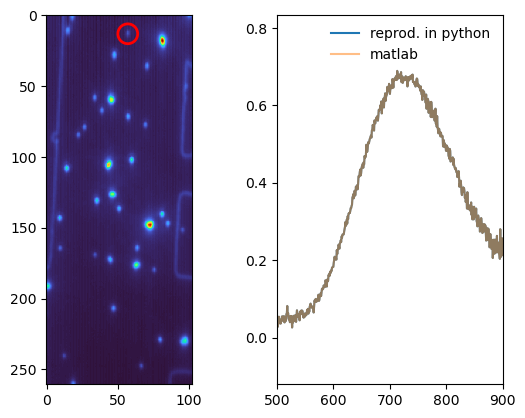

In [25]:
positions = np.loadtxt('data_from_2024-12-21/mg110_glyc_33/positions.txt')
npi = 0

xi = int(positions[npi,0])-1
yi = int(positions[npi,1])-1


print(xi,yi)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.sum(specfin,2).T, cmap='turbo')
ax[0].add_patch(plt.Circle([xi, yi], radius=7, edgecolor='r',lw=2, fill=False))        

sum_over_three = np.round((specfin[xi+1,yi-1,:]+specfin[xi,yi-1,:]+specfin[xi-1,yi-1,:]+
                           specfin[xi+1,yi,:]+  specfin[xi,yi,:]+  specfin[xi-1,yi,:]+
                           specfin[xi+1,yi+1,:]+specfin[xi,yi+1,:]+specfin[xi-1,yi+1,:]), 5)


ax[1].plot(wave_raw,sum_over_three,
           label='reprod. in python')


ax[1].set_xlim([500,900])


mat = scipy.io.loadmat('data_from_2024-12-21/mg110_glyc_33/all_spectra_mg110_glyc_33.mat')
allSpec_end = np.round(mat['allSpec'],5)
waves_mat_end = mat['rawwvlths'].reshape(571,1)

ax[1].plot(waves_mat_end, allSpec_end[:,npi], label='matlab', alpha=.5)
ax[1].legend(frameon=False)


print(max(allSpec_end[:,npi] - sum_over_three[99:]))




[ 0.00622  0.06757  0.03858  0.02407  0.10479  0.06783  0.04258 -0.0067
  0.05062  0.0627 ]
[ 0.00622  0.06757  0.03858  0.02407  0.10479  0.06783  0.04258 -0.0067
  0.05062  0.0627 ]


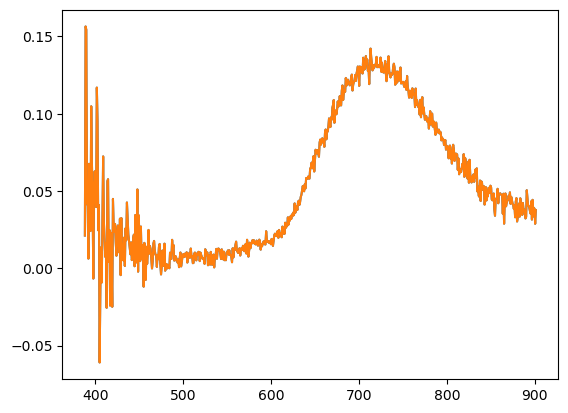

In [26]:
## Verify that the values exactly match

mat = scipy.io.loadmat('data_from_2024-12-21/mg110_glyc_33analysis.mat')
specfin_mat = np.round(mat['specfin'],5)
wvlths_mat = mat['wvlths'].reshape(670,1)

plt.plot(wvlths_mat.reshape(670,), specfin_mat[14-1,58-1,:], label='matlab')

plt.plot(wave_raw, specfin[58-1,14-1,:], label='python')


# plt.legend(frameon=False)
print(specfin_mat[14-1,58-1,5:15])
print(specfin[58-1,14-1,5:15])